# Entity Extraction from Tables

This notebook demonstrates the full extraction and learning process for _entities_ in tables with a data set of transistor spec sheets, extracting minimum storage temperatures.

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Extraction

In [2]:
load_pickle = False #with pickling, ~30s; without pickling, ~90s
save_pickle = False

corpus_loaded = False
import cPickle
if load_pickle:
    try:
        with open("data/hardware/hardware_corpus.pkl","r") as pkl:
            %time corpus = cPickle.load(pkl)
        corpus_loaded = True
        print "Corpus has been loaded."
    except:
        print "Corpus could not be loaded."
        print "Corpus will be parsed instead..."
if not corpus_loaded:
    from snorkel.parser import CorpusParser
    from snorkel.parser import HTMLParser
    from snorkel.parser import TableParser

    html_parser = HTMLParser(path='data/hardware/hardware_html/')
    table_parser = TableParser()

    cp = CorpusParser(html_parser, table_parser, max_docs=200)
    %time corpus = cp.parse_corpus(name='Hardware Corpus')
    print "Corpus has been parsed."

    if save_pickle:
        with open("data/hardware/hardware_corpus.pkl","w") as pkl:
            %time corpus = cPickle.dump(corpus, pkl)
            print "Corpus has been pickled."

CPU times: user 55.4 s, sys: 969 ms, total: 56.4 s
Wall time: 1min 25s
Corpus has been parsed.


In [3]:
from snorkel.candidates import TableNgrams
from snorkel.matchers import NumberMatcher, RangeMatcher

# Define a candidate space
ngrams = TableNgrams(n_max=3)

# Define a matcher
number_matcher = RangeMatcher(low=-70,high=-50)

In [4]:
from snorkel.candidates import EntityExtractor
ce = EntityExtractor(ngrams, number_matcher)
%time candidates = ce.extract(corpus.get_tables(), name='all')
for cand in candidates[:10]: 
    print cand
print "%s candidates extracted" % len(candidates)

CPU times: user 22.2 s, sys: 578 ms, total: 22.8 s
Wall time: 22.9 s
Ngram("-55", context=None, chars=[297,299], words=[0,0])
Ngram("-50", context=None, chars=[414,416], words=[0,0])
Ngram("-50", context=None, chars=[494,496], words=[0,0])
Ngram("-50", context=None, chars=[683,685], words=[2,2])
Ngram("-50", context=None, chars=[854,856], words=[2,2])
Ngram("-50", context=None, chars=[991,993], words=[2,2])
Ngram("-55", context=None, chars=[294,296], words=[0,0])
Ngram("-55", context=None, chars=[292,294], words=[0,0])
Ngram("-55", context=None, chars=[355,357], words=[0,0])
Ngram("-50", context=None, chars=[410,412], words=[0,0])
108 candidates extracted


### Learning

First, generate gold data.

In [5]:
from utils import collect_hardware_entity_gold
filename='data/hardware/gold_all.csv'
gt_dict = collect_hardware_entity_gold(filename, 'stg_temp_min', candidates)
print "%s out of %s candidates have gold labels" % (len(gt_dict),len(candidates))
print "%s out of %s labeled candidates have positive label" \
        % (gt_dict.values().count(1), len(gt_dict))

98 gold annotations
59 out of 108 candidates have gold labels
51 out of 59 labeled candidates have positive label


Let's take a quick peek at the features:

In [6]:
from snorkel.features import TableNgramFeaturizer
featurizer = TableNgramFeaturizer()
featurizer.fit_transform(candidates)
for f in featurizer.get_features_by_candidate(candidates[0])[:]: print f

DDLIB_WORD_SEQ_[-55]
DDLIB_LEMMA_SEQ_[-55]
DDLIB_POS_SEQ_[CD]
DDLIB_DEP_SEQ_[ROOT]
DDLIB_W_LEFT_1_[_NUMBER]
DDLIB_W_LEFT_POS_1_[CD]
DDLIB_W_LEFT_2_[to _NUMBER]
DDLIB_W_LEFT_POS_2_[TO CD]
DDLIB_W_LEFT_3_[_NUMBER to _NUMBER]
DDLIB_W_LEFT_POS_3_[CD TO CD]
DDLIB_W_RIGHT_1_[to]
DDLIB_W_RIGHT_POS_1_[TO]
DDLIB_W_RIGHT_2_[to _NUMBER]
DDLIB_W_RIGHT_POS_2_[TO CD]
DDLIB_W_LEMMA_L_1_R_1_[_NUMBER]_[to]
DDLIB_W_POS_L_1_R_1_[CD]_[TO]
DDLIB_W_LEMMA_L_1_R_2_[_NUMBER]_[to _NUMBER]
DDLIB_W_POS_L_1_R_2_[CD]_[TO CD]
DDLIB_W_LEMMA_L_2_R_1_[to _NUMBER]_[to]
DDLIB_W_POS_L_2_R_1_[TO CD]_[TO]
DDLIB_W_LEMMA_L_2_R_2_[to _NUMBER]_[to _NUMBER]
DDLIB_W_POS_L_2_R_2_[TO CD]_[TO CD]
DDLIB_W_LEMMA_L_3_R_1_[_NUMBER to _NUMBER]_[to]
DDLIB_W_POS_L_3_R_1_[CD TO CD]_[TO]
DDLIB_W_LEMMA_L_3_R_2_[_NUMBER to _NUMBER]_[to _NUMBER]
DDLIB_W_POS_L_3_R_2_[CD TO CD]_[TO CD]
DDLIB_NUM_WORDS_1
TABLE_ROW_NUM_[5]
TABLE_COL_NUM_[2]
TABLE_HTML_TAG_td
TABLE_HTML_ATTR_style=width:108pt
TABLE_HTML_ANC_TAG_tr
TABLE_HTML_ANC_TAG_table
TABLE_HTML

We now build a legacy DDLiteModel with which we will do learning.

In [7]:
from snorkel.snorkel import DDLiteModel
DDL = DDLiteModel(candidates, featurizer.fit_transform(candidates), gt_dict)

DDL.set_holdout(idxs=range(int(len(gt_dict)*.8)), validation_frac=0.5)
print "%s training data" % len(DDL.gt.get_labeled_ground_truth('training')[0])
print "%s test data" % len(DDL.gt.get_labeled_ground_truth('test')[0])
print "%s validation data" % len(DDL.gt.get_labeled_ground_truth('validation')[0])

31 training data
15 test data
13 validation data


Define labeling functions:

In [8]:
def LF_to_range(m):
    return 1 if 'to' in m.post_window('words') else 0
def LF_tilde_range(m):
    return 1 if '~' in m.post_window('words') else 0
def LF_storage(m):
    return 1 if 'storage' in m.aligned_ngrams('words') else -1
def LF_tstg(m):
    return 1 if 'tstg' in m.aligned_ngrams('words') else -1
def LF_tj(m):
    return 1 if 'tj' in m.aligned_ngrams('words') else -1
def LF_temperature(m):
    return 1 if 'temperature' in m.aligned_ngrams('words') else -1
def LF_celsius(m):
    return 1 if 'c' in m.aligned_ngrams('words') else -1
def LF_max(m):
    return 1 if 'max' in m.aligned_ngrams('words') else 0
def LF_min(m):
    return 1 if 'min' in m.aligned_ngrams('words') else 0

In [9]:
LFs = [LF_to_range, LF_tilde_range, LF_storage, LF_tstg, LF_tj, LF_temperature,
      LF_celsius, LF_max, LF_min]
DDL.apply_lfs(LFs, clear=True)

In [10]:
print DDL.lf_names
DDL.print_lf_stats()

['LF_to_range', 'LF_tilde_range', 'LF_storage', 'LF_tstg', 'LF_tj', 'LF_temperature', 'LF_celsius', 'LF_max', 'LF_min']
LF stats on training set
Coverage:	100.000%
Overlap:	100.000%
Conflict:	59.016%


Now learn, baby, learn!

Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.480100
	Learning epoch = 250	Gradient mag. = 0.539328
Final gradient magnitude for rate=0.01, mu=1e-07: 0.420
Running in False mode...
Begin training for rate=0.01, mu=1e-09
	Learning epoch = 0	Gradient mag. = 0.202577
	Learning epoch = 250	Gradient mag. = 0.212104
	Learning epoch = 500	Gradient mag. = 0.210982
	Learning epoch = 750	Gradient mag. = 0.209874
	Learning epoch = 1000	Gradient mag. = 0.208779
	Learning epoch = 1250	Gradient mag. = 0.207697
	Learning epoch = 1500	Gradient mag. = 0.206629
	Learning epoch = 1750	Gradient mag. = 0.205573
	Learning epoch = 2000	Gradient mag. = 0.204530
	Learning epoch = 2250	Gradient mag. = 0.203500
	Learning epoch = 2500	Gradient mag. = 0.202481
	Learning epoch = 2750	Gradient mag. = 0.201475
Final gradient magnitude for rate=0.01, mu=1e-09: 0.200
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.202577
	Learning epoch = 250	Gradient mag. = 0

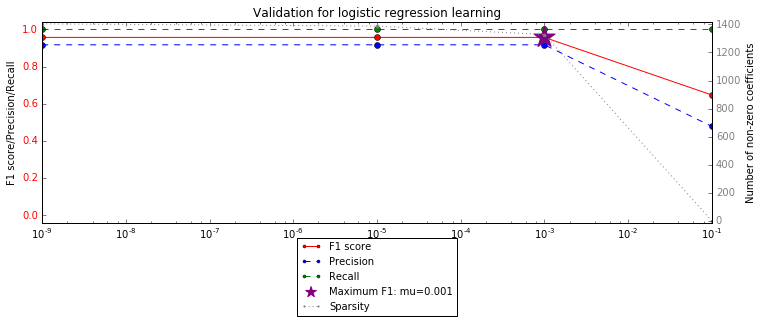

CPU times: user 3.56 s, sys: 44.3 ms, total: 3.61 s
Wall time: 3.62 s


<snorkel.snorkel.ModelLog instance at 0x1628f22d8>

In [11]:
import matplotlib
import numpy as np
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,4)
mu_seq = np.ravel([1e-9, 1e-5, 1e-3, 1e-1])
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'sample': False, 'n_iter': 3000, 'alpha': 0.5, 'mu': mu_seq, 'bias': False, 'verbose': True}
%time DDL.train_model(method='lr', lf_opts=lf_opts, model_opts=model_opts)

Tune in next time for relation extraction!